In [1]:
from temporora import * 

Processing dataset: FD001
Epoch [1/50], Loss: 0.0215
Epoch [2/50], Loss: 0.0208
Epoch [3/50], Loss: 0.0156
Epoch [4/50], Loss: 0.0148
Epoch [5/50], Loss: 0.0120
Epoch [6/50], Loss: 0.0132
Epoch [7/50], Loss: 0.0148
Epoch [8/50], Loss: 0.0117
Epoch [9/50], Loss: 0.0124
Epoch [10/50], Loss: 0.0127
Epoch [11/50], Loss: 0.0079
Epoch [12/50], Loss: 0.0073
Epoch [13/50], Loss: 0.0138
Epoch [14/50], Loss: 0.0083
Epoch [15/50], Loss: 0.0075
Epoch [16/50], Loss: 0.0069
Epoch [17/50], Loss: 0.0113
Epoch [18/50], Loss: 0.0080
Epoch [19/50], Loss: 0.0077
Epoch [20/50], Loss: 0.0116
Epoch [21/50], Loss: 0.0094
Epoch [22/50], Loss: 0.0101
Epoch [23/50], Loss: 0.0075
Epoch [24/50], Loss: 0.0077
Epoch [25/50], Loss: 0.0055
Epoch [26/50], Loss: 0.0080
Epoch [27/50], Loss: 0.0061
Epoch [28/50], Loss: 0.0133
Epoch [29/50], Loss: 0.0079
Epoch [30/50], Loss: 0.0067
Epoch [31/50], Loss: 0.0087
Epoch [32/50], Loss: 0.0082
Epoch [33/50], Loss: 0.0084
Epoch [34/50], Loss: 0.0062
Epoch [35/50], Loss: 0.0056
Epo

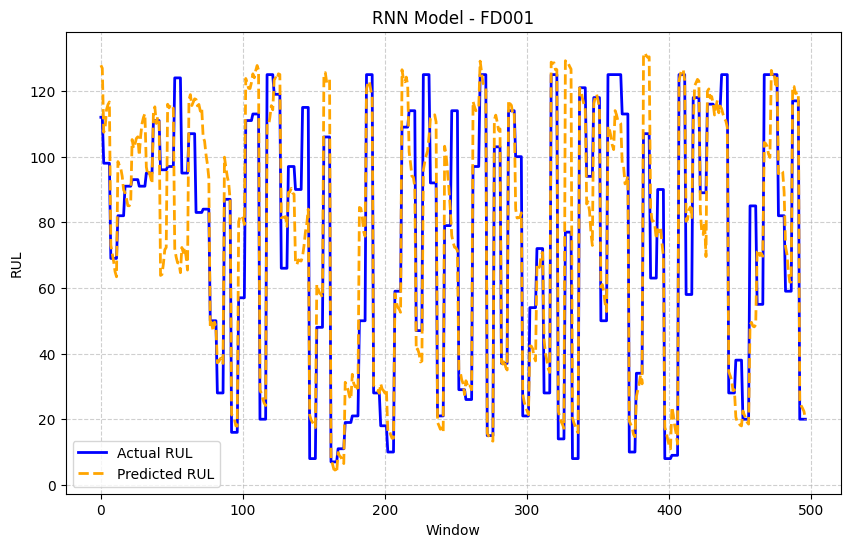

Processing dataset: FD002
Epoch [1/50], Loss: 0.0364
Epoch [2/50], Loss: 0.0209
Epoch [3/50], Loss: 0.0281
Epoch [4/50], Loss: 0.0233
Epoch [5/50], Loss: 0.0229
Epoch [6/50], Loss: 0.0149
Epoch [7/50], Loss: 0.0244
Epoch [8/50], Loss: 0.0202
Epoch [9/50], Loss: 0.0176
Epoch [10/50], Loss: 0.0223
Epoch [11/50], Loss: 0.0180
Epoch [12/50], Loss: 0.0235
Epoch [13/50], Loss: 0.0126
Epoch [14/50], Loss: 0.0138
Epoch [15/50], Loss: 0.0137
Epoch [16/50], Loss: 0.0150


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    args.sub_dataset = dataset

    train_loader, valid_loader, test_loader, test_loader_last, num_test_windows, train_visualize, engine_id = get_dataloader(
        dir_path=args.dataset_root,
        sub_dataset=args.sub_dataset,
        max_rul=args.max_rul,
        seq_length=args.sequence_len,
        batch_size=args.batch_size,
        use_exponential_smoothing=args.use_exponential_smoothing,
        smooth_rate=args.smooth_rate)

    input_size = args.feature_num
    hidden_size = 64
    num_layers = 2
    output_size = 1

    num_epochs = 50

    rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        rnn_model.train()
        for x, y in train_loader:
            x = x.view(-1, args.sequence_len, args.feature_num).to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = rnn_model(x)
            loss = criterion(outputs, y.view(-1, 1))

            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    rnn_model.eval()
    valid_predictions, valid_actuals = [], []
    test_predictions, test_actuals = [], []

    with torch.no_grad():
        for x, y in valid_loader:
            x = x.view(-1, args.sequence_len, args.feature_num).to(device)
            y = y.to(device)
            preds = rnn_model(x)
            valid_predictions.extend(preds.cpu().numpy())
            valid_actuals.extend(y.cpu().numpy())

    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(-1, args.sequence_len, args.feature_num).to(device)
            y = y.to(device)
            preds = rnn_model(x)
            test_predictions.extend(preds.cpu().numpy())
            test_actuals.extend(y.cpu().numpy())

    valid_predictions = np.array(valid_predictions).flatten()
    valid_predictions = valid_predictions * args.max_rul
    valid_actuals = np.array(valid_actuals).flatten()
    valid_actuals = valid_actuals * args.max_rul
    test_predictions = np.array(test_predictions).flatten()
    test_actuals = np.array(test_actuals).flatten()
    test_actuals = test_actuals * args.max_rul
    test_predictions = test_predictions * args.max_rul

    valid_mse = mean_squared_error(valid_actuals, valid_predictions)
    valid_rmse = np.sqrt(valid_mse)
    valid_r2 = r2_score(valid_actuals, valid_predictions)

    test_mse = mean_squared_error(test_actuals, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_predictions)

    metrics[dataset] = {
        "Validation MSE": valid_mse,
        "Validation RMSE": valid_rmse,
        "Validation R2": valid_r2,
        "Test MSE": test_mse,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    }

    print(f"Dataset {dataset} Metrics:")
    print(f"Validation MSE: {valid_mse:.4f}, RMSE: {valid_rmse:.4f}, R2: {valid_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(test_actuals, label='Actual RUL', color='blue', linewidth=2)
    plt.plot(test_predictions, label='Predicted RUL', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Window')
    plt.ylabel('RUL')
    plt.title(f'RNN Model - {dataset}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
